In [2]:
%%HTML
<style> code {background-color : pink !important;} </style>

Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

File camera_cal/calibration5.jpg Could not be used for calibration
File camera_cal/calibration4.jpg Could not be used for calibration
File camera_cal/calibration1.jpg Could not be used for calibration
17 out of 20 images were used for calibration


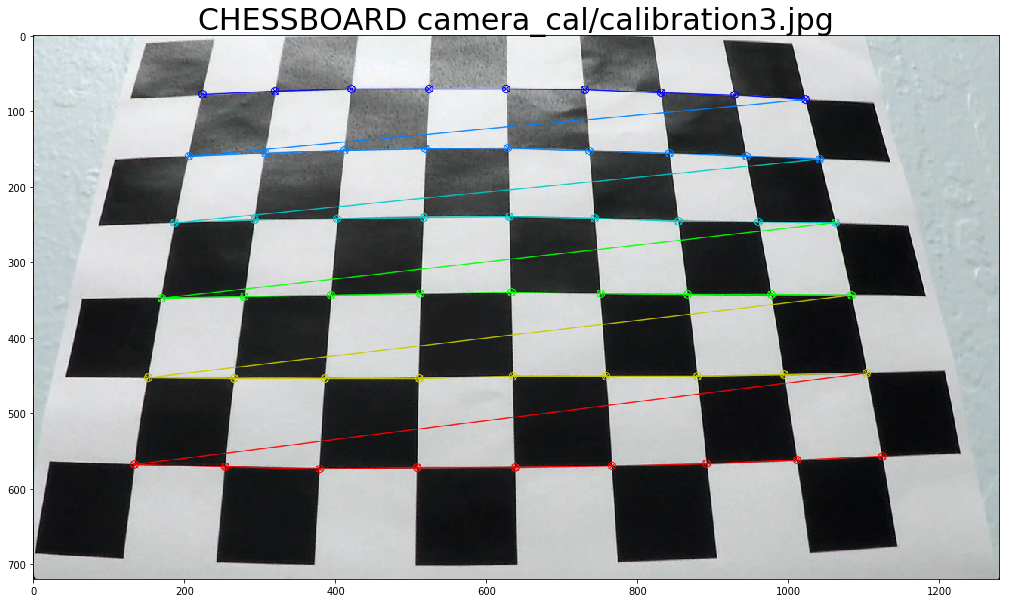

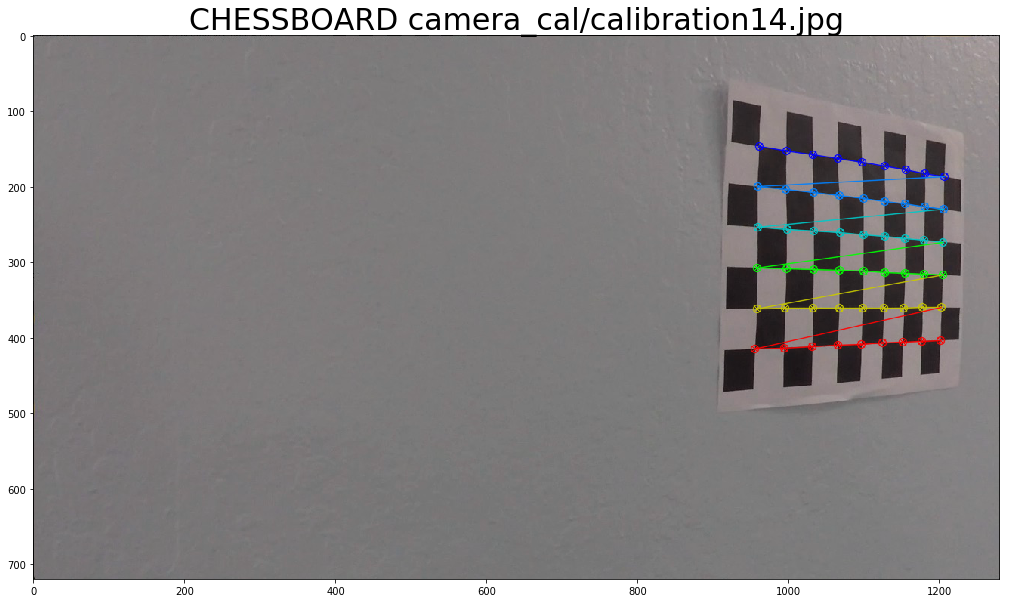

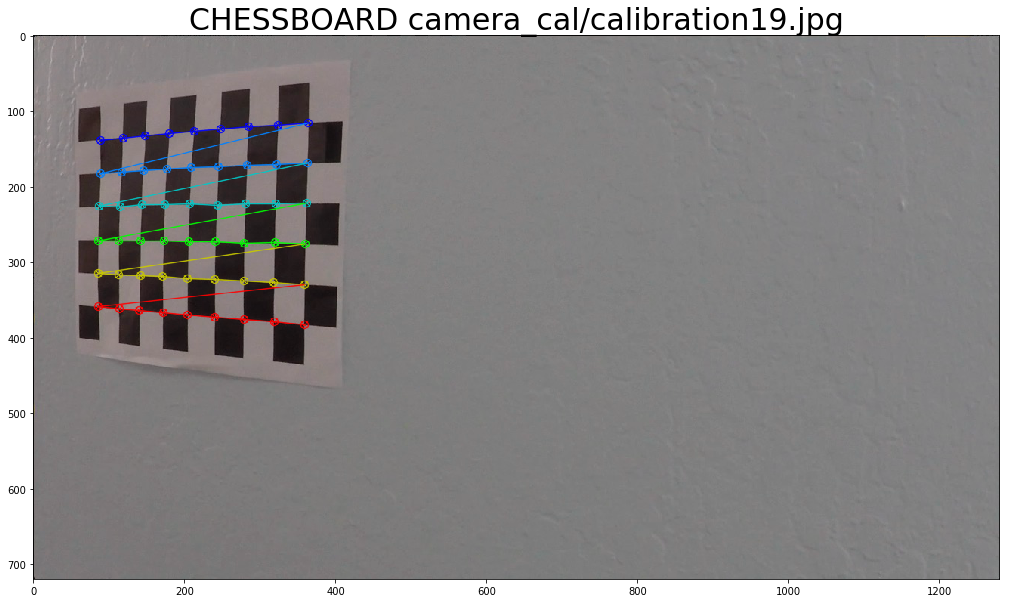

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

### BEGIN GLOBAL CONSTANTS ####
CALIB_NROWSS=6
CALIB_NCOLSS=9
CALIBRATION_IMAGE_GLOB='camera_cal/calibration*.jpg'

### END   GLOBAL CONSTANTS ###

def toGray () :
    return cv2.COLOR_BGR2GRAY

def toHLS () :
    return cv2.COLOR_BGR2HLS

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# Find Chess board corners, just a wrapper around cv2 function
def chessboardCorners (gray_img, nrows, ncols) :
    return cv2.findChessboardCorners (gray_img, (ncols, nrows), None)

def drawChessboard (image, nrows, ncols, corners, returncode, caption) :
    img = image
    cv2.drawChessboardCorners(img, (ncols,nrows), corners, returncode)
    f_dc, ax_dc = plt.subplots(figsize=(20,10))
    ax_dc.imshow(img)
    ax_dc.set_title('CHESSBOARD {}'.format(caption), fontsize=30)

# Opens each file matching the imageFilePattern and
# computes the object points and image points.
# These are then concatenated and returned.
# Returns the object and image points.
def calibrationPoints (imageFilePattern, nrows, ncols, displayImgCount=0) :
    objp = np.zeros((nrows*ncols,3), np.float32)
    objp[:,:2] = np.mgrid[0:ncols, 0:nrows].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(imageFilePattern)
    cal_imgs_count = 0
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, toGray())
        # Find the chessboard corners
        ret, corners = chessboardCorners (gray, nrows, ncols)
        # If found, add object points, image points
        #cv2.imshow ('img', img)
        #cv2.waitKey(500)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cal_imgs_count += 1
            if cal_imgs_count <= displayImgCount:
                drawChessboard (img, nrows, ncols, corners, ret, "{}".format(fname))
        else :
            print ("File {} Could not be used for calibration".format (fname))
    print ("{} out of {} images were used for calibration".format (cal_imgs_count, len(images)))
    return objpoints, imgpoints

objpoints, imgpoints = calibrationPoints (CALIBRATION_IMAGE_GLOB, CALIB_NROWSS, CALIB_NCOLSS, 3)            

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

Size camera_cal/calibration2.jpg, (720, 1280, 3)


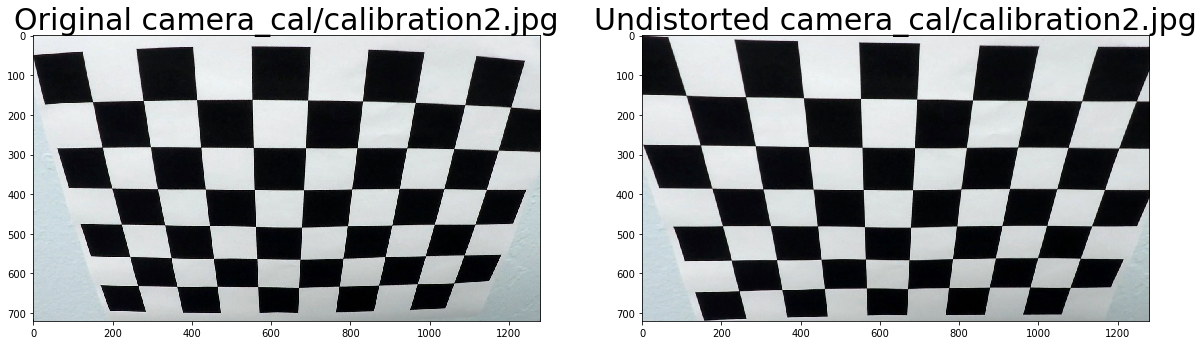

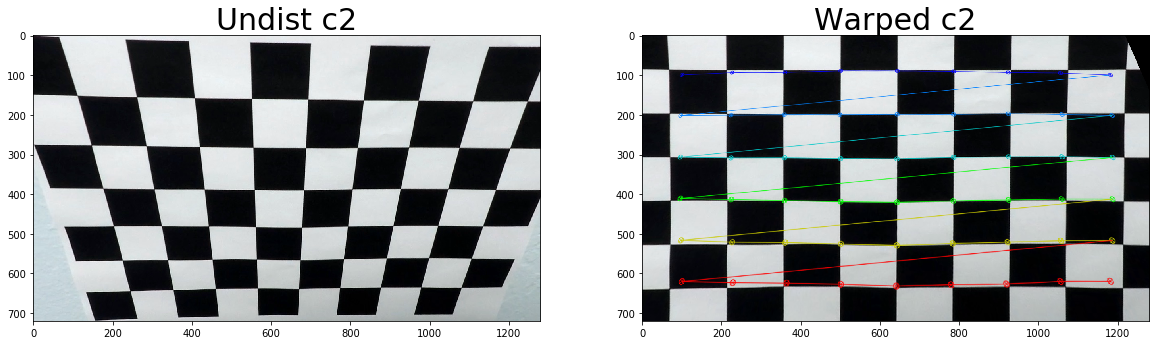

In [4]:
# Undistorts an img
# Returns undistorted image, camera matrix, distortion coefficients, rvecs, tvecs
def Undistort (img, objpoints, imgpoints) :
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    #print ("Camera Calibration Parameters ret = {}, matrix = {}, distortion = {}, rvecs = {}, tvecs = {}".format (
    #        ret, mtx, dist, rvecs, tvecs))
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst, mtx, dist, rvecs, tvecs

def UndistortUsingCalibrationParams (img, mtx, dist) :
    return cv2.undistort (img, mtx, dist, None, mtx)

def corners_warp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, toGray())
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(cv2.cvtColor(img, toGray()), (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

#cv2.imwrite('camera_cal/1_out.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
def testUndistortImage (fname) :
    img = cv2.imread(fname)
    print ("Size {}, {}".format (fname, img.shape))
    dst, mtx, dist, rvecs, tvecs = Undistort (img, objpoints, imgpoints)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original {}'.format(fname), fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted {}'.format(fname), fontsize=30)
    return dst, mtx, dist, rvecs, tvecs

undist, mtx, dist, rvecs, tvecs = testUndistortImage ('camera_cal/calibration2.jpg')
warped, M = corners_warp (cv2.imread ('camera_cal/calibration2.jpg'), CALIB_NCOLSS, CALIB_NROWSS, mtx, dist)
f, (ax1, ax2) = plt.subplots (1, 2, figsize=(20,10))
ax1.imshow (undist)
ax1.set_title ("Undist {}".format ('c2'), fontsize=30)
ax2.imshow (warped)
ax2.set_title ("Warped {}".format ('c2'), fontsize=30)
#testUndistortImage ('camera_cal/calibration3.jpg')
#testUndistortImage ('camera_cal/calibration12.jpg')
#testUndistortImage ('camera_cal/calibration14.jpg')
#testUndistortImage ('camera_cal/calibration19.jpg')


In [5]:
############## ---- GRAIDENT THESHOLDING ------------####################
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gimg = cv2.cvtColor (img, toGray ())
    sobelx = np.absolute (cv2.Sobel (gimg, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute (cv2.Sobel (gimg, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    direc = np.arctan2 (sobely, sobelx)
    binary_output = np.zeros_like(direc)
    binary_output[(direc >= thresh [0]) & (direc <= thresh[1])] = 1
    return binary_output

# Compute the sobel operator of a
# grayscale image based on orientation.
def sobel_orient (gimg, orient, sobel_kernel):
    if orient == 'x' :
        return cv2.Sobel (gimg, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y' :
        return cv2.Sobel (gimg, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else :
        raise 'INVALID ORIENTATION specified'
        return None


# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    gimg = cv2.cvtColor (img, toGray ())
    sobelO = sobel_orient (gimg, orient, sobel_kernel)
    abs_sobelO = np.absolute(sobelO)
    scaled_sobel = np.uint8(255*abs_sobelO/np.max(abs_sobelO))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gimg = cv2.cvtColor (img, toGray ())
    sobelx = cv2.Sobel (gimg, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel (gimg, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt (np.multiply (sobelx, sobelx) + np.multiply (sobely, sobely))
    scaled_mag = np.uint8 (255 * mag / np.max (mag))
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1

    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    return binary_output


############## ---- GRAIDENT THESHOLDING ------------####################

In [6]:
############--------- COLOR THRESHOLD --------------##############

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, toHLS())
    S = hls [:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    return binary_output

############--------- COLOR THRESHOLD --------------##############

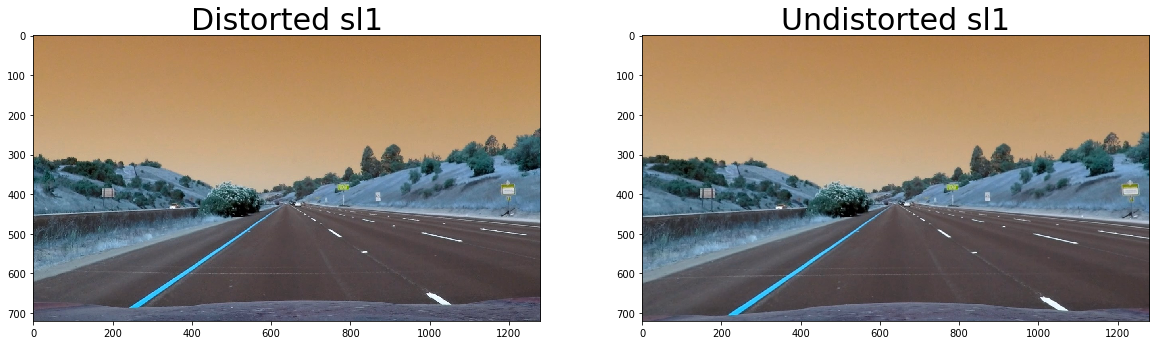

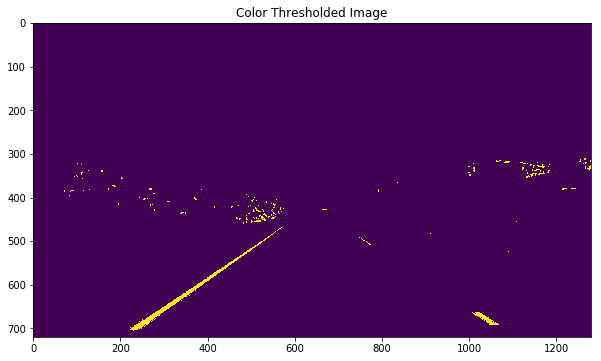

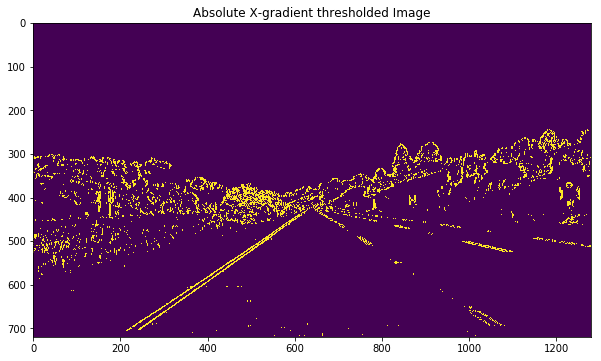

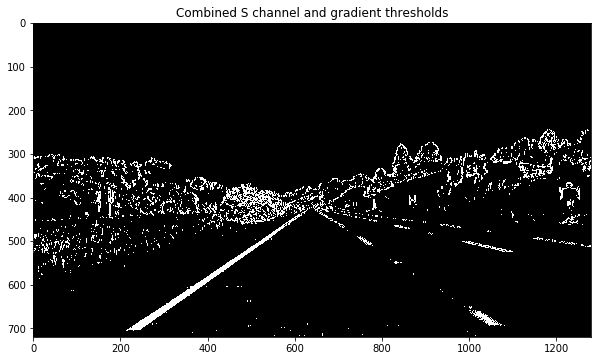

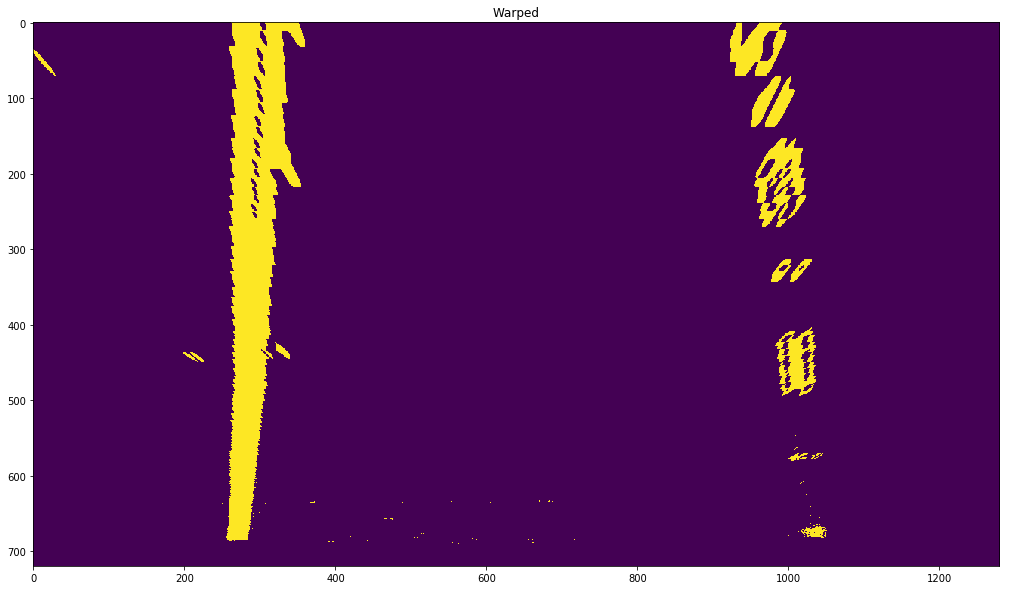

In [7]:
#######---- PIPELINE --------- ###########
   
def undist_threshold_warp_img (img, mtx, dist, display_results=False) :
    undist = UndistortUsingCalibrationParams (img, mtx, dist)
    if (display_results) :
        f, (ax1, ax2) = plt.subplots (1, 2, figsize=(20,10))
        ax1.imshow (img)
        ax1.set_title ("Distorted {}".format ('sl1'), fontsize=30)
        ax2.imshow (undist)
        ax2.set_title ("Undistorted {}".format ('sl1'), fontsize=30)    
    color_thresh = hls_select (undist, (170, 255))
    if (display_results) :
        fC, axC = plt.subplots(figsize=(10,10))
        axC.imshow (color_thresh)
        axC.set_title ("Color Thresholded Image")
    
    absx_thresh = abs_sobel_thresh(undist, 'x', 3, 20, 100)
    if (display_results) :
        fAbsX, axAbsX = plt.subplots (figsize=(10,10))
        axAbsX.imshow (absx_thresh)
        axAbsX.set_title ("Absolute X-gradient thresholded Image")
    
    combined_binary = np.zeros_like(absx_thresh)
    combined_binary[(color_thresh == 1) | (absx_thresh == 1)] = 1
    if (display_results) :
        fComb, axComb = plt.subplots (figsize=(10,10))
        axComb.set_title('Combined S channel and gradient thresholds')
        axComb.imshow(combined_binary, cmap='gray')
    
    SRC = np.float32 ([[258, 675], [1039, 675], [590, 450], [695, 450]])
    DST = np.float32 ([[258, 675], [1039, 675], [258, 0], [1039, 0]])
    M = cv2.getPerspectiveTransform (SRC, DST)
    Minv = cv2.getPerspectiveTransform (DST, SRC)
    warped = cv2.warpPerspective (combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]))
    if (display_results):
        fWarped, axWarp = plt.subplots (figsize=(20,10))
        axWarp.set_title ('Warped')
        axWarp.imshow (warped)
    
    return warped, M, Minv
    

img = cv2.imread ('test_images/straight_lines1.jpg')
binary_warped, M, Minv = undist_threshold_warp_img (img, mtx, dist, True)


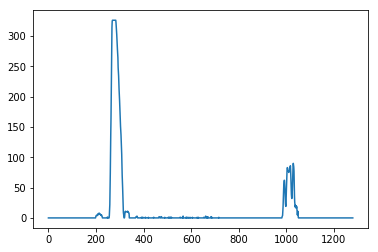

In [8]:
### ---- Lane Finding --- ###
histo = np.sum (binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot (histo)

In [9]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
def calculate_curvature (poly_coeff, ym_per_pixel, y_eval) :
    return ((1 + (2*poly_coeff[0]*y_eval*ym_per_pixel + poly_coeff[1])**2)**1.5) / np.absolute(2*poly_coeff[0])


def lane_breadth (left_coeff, right_coeff, y_eval) :
    lx = left_coeff[0] * (y_eval**2) + left_coeff[1]*y_eval + left_coeff[0]
    rx = right_coeff[0] * (y_eval**2) + right_coeff[1]*y_eval + right_coeff[0]
    return np.abs (lx - rx)

def vehicle_pos (left_coeff, right_coeff, y_eval, xmax, xm_per_pix) :
    lx = left_coeff[0] * (y_eval**2) + left_coeff[1]*y_eval + left_coeff[0]
    rx = right_coeff[0] * (y_eval**2) + right_coeff[1]*y_eval + right_coeff[0]
    mid_lane = (lx + rx) / 2.0
    img_center = xmax / 2.0
    position = (img_center - mid_lane)
    return position * xm_per_pix

def vehicle_pos_msg (pos):
    if pos >= 0 :
        return "Vehicle Pos : {} from the left".format (pos)
    else :
        return "Vehicle Pos: {} from the right".format (np.abs(pos))


def histogram_lane_pixels (binary_warped) :
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    #leftx = nonzerox[left_lane_inds]
    #lefty = nonzeroy[left_lane_inds] 
    #rightx = nonzerox[right_lane_inds]
    #righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    return left_lane_inds, right_lane_inds, out_img

def fit_polynomial (xIndices, yIndices, degree=2) :
    return np.polyfit (yIndices, xIndices, degree)

left_lane_inds, right_lane_inds, out_img = histogram_lane_pixels (binary_warped)
nonzero = binary_warped.nonzero()
print ("Binary warped type {}, shape {}".format (type(binary_warped), np.shape (binary_warped)))
print ("Nonzero shape type {}, shape {}".format (type(nonzero), np.shape(nonzero)))
print ("Nonzero shapey type {}, shape {}".format (type(nonzero[0]), np.shape(nonzero[0])))
print ("Nonzero shapex type {}, shape {}".format (type(nonzero[1]), np.shape(nonzero[1])))
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
left_fit = fit_polynomial (leftx, lefty, 2)
right_fit = fit_polynomial (rightx, righty, 2)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
y_eval = np.max(ploty)
cL = calculate_curvature (left_fit, 1.0, np.max (ploty))
cR = calculate_curvature (right_fit, 1.0, np.max (ploty))
print ("Left Curvature {}, Right Curvature {}".format (cL, cR))
xmax = binary_warped.shape[1]
vehicle_pos_msg (vehicle_pos (left_fit, right_fit, y_eval, xmax, 1))

left_fitm = np.polyfit (lefty * ym_per_pix, leftx *xm_per_pix, 2)
right_fitm = np.polyfit (righty * ym_per_pix, rightx *xm_per_pix, 2)


cLm = calculate_curvature (left_fitm, ym_per_pix, y_eval)
cRm = calculate_curvature (right_fitm, ym_per_pix, y_eval)
print ("Left Curvature {}m, Right Curvature {}m".format (cLm, cRm))
print ("Average Curvature {}m".format ((cLm + cRm)/2.0))
vehicle_pos_msg (vehicle_pos (left_fitm, right_fitm, y_eval *ym_per_pix, xmax, xm_per_pix))

Binary warped type <class 'numpy.ndarray'>, shape (720, 1280)
Nonzero shape type <class 'tuple'>, shape (2, 49069)
Nonzero shapey type <class 'numpy.ndarray'>, shape (49069,)
Nonzero shapex type <class 'numpy.ndarray'>, shape (49069,)
Left Curvature 25723.003937816866, Right Curvature 4766.156864073744
Left Curvature 8403.64552118622m, Right Curvature 1564.0151957075418m
Average Curvature 4983.83035844688m


'Vehicle Pos : 3.382313221122827 from the left'

(720, 0)

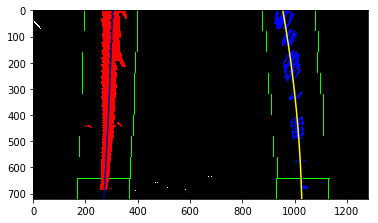

In [10]:
# Generate x and y values for plotting

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='darkblue')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [11]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
cL = calculate_curvature (left_fit, 1.0, np.max (ploty))
cR = calculate_curvature (right_fit, 1.0, np.max (ploty))
print ("Left Curvature {}, Right Curvature {}".format (cL, cR))

vehicle_pos_msg (vehicle_pos (left_fit, right_fit, y_eval, xmax, 1.0))

Left Curvature 26726.539210984927, Right Curvature 4766.156864072549


'Vehicle Pos : 620.4282841027674 from the left'

In [12]:
cLm = calculate_curvature (left_fitm, ym_per_pix, 500)
cRm = calculate_curvature (right_fitm, ym_per_pix, 500)
print ("Left Curvature {}m, Right Curvature {}m".format (cLm, cRm))
print ("Average Curvature {}m".format ((cLm + cRm)/2.0))

vehicle_pos_msg (vehicle_pos (left_fitm, right_fitm, y_eval *ym_per_pix, xmax, xm_per_pix))


Left Curvature 8403.450907440516m, Right Curvature 1564.1819546313782m
Average Curvature 4983.816431035947m


'Vehicle Pos : 3.382313221122827 from the left'

(720, 0)

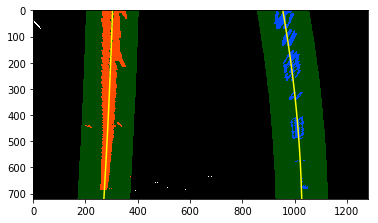

In [13]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [14]:
#This class maintains a moving average of coefficients of a polynomial
class PolyMovingAverage ():
    def __init__ (self, window_size,degree=2): 
       self.history = []
       self.window_size = window_size 
       self.window_count = 0
       self.best_coeffs = np.zeros(degree+1, dtype='float')
       self.sum_coeffs = np.zeros(degree+1, dtype='float')
    
    def norm_best (self) :
        return np.linalg.norm (self.best_coeffs)
    
    #Compute the norm of the difference in coefficients
    def norm_diff (self, new_poly) :
        normBest = self.norm_best()
        normNew = np.linalg.norm (new_poly)
        normDiff = np.linalg.norm (self.best_coeffs - new_poly)
        #print ("normBest = {}, normNew = {}, normDiff = {} ".format (normBest, normNew, normDiff))
        return normDiff
    #Update with new coefficients
    def update (self, new_poly, reset=False):
       if (True == reset) :
           self.history = []
           self.window_count = 1
           self.best_coeffs = new_poly
           self.sum_coeffs = self.best_coeffs
           return
       if (self.window_count < self.window_size) :
           self.window_count += 1
           self.history.append (new_poly)
           self.sum_coeffs += new_poly
           self.best_coeffs = self.sum_coeffs / self.window_count
       elif (self.window_count == self.window_size) :
           new_hist = self.history [1:]
           self.sum_coeffs -= self.history[0]
           self.sum_coeffs += new_poly
           new_hist.append (new_poly)
           self.history = new_hist
           self.best_coeffs = self.sum_coeffs/self.window_count
       else :
           raise 'ERROR: Window count can never be more than window size'
    def best_poly (self) :
       return self.best_coeffs
    def dump (self) :
       print ("History = {} ".format (self.history))
       print ("window_count = {} ".format (self.window_count))
       print ("sum_coeffs = {} ".format (self.sum_coeffs))
       print ("best_coeffs = {} ".format (self.best_coeffs))

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        self.sum_window_size = 5
        self.sum_window_count = 0
        self.diff_tolerance = 0.1
        #Data structures maintaining moving average.
        self.left_mov_avg = PolyMovingAverage (self.sum_window_size)
        self.right_mov_avg = PolyMovingAverage (self.sum_window_size)
        self.left_mov_avgm = PolyMovingAverage (self.sum_window_size)        
        self.right_mov_avgm = PolyMovingAverage (self.sum_window_size)
        self.frame_count  = 0 # Frame count for debugging
    
    def reset_polynomials (self, left_fit, right_fit, left_fitm, right_fitm, lane_breadth) :
        if (lane_breadth < 3 and lane_breadth > 3.9) :
            return True
        if (self.detected == False) :
            return True
        resetPolys = False
        #If we find a huge norm difference, greater than fraction defined in self.diff_tolerance
        lnorm_best = self.left_mov_avg.norm_best ()
        lnorm_diff = self.left_mov_avg.norm_diff (left_fit)
        if (lnorm_best != 0 and lnorm_diff/lnorm_best > self.diff_tolerance) :
            resetPolys = True
        rnorm_best = self.right_mov_avg.norm_best ()
        rnorm_diff = self.right_mov_avg.norm_diff (right_fit)
        if (rnorm_best != 0 and rnorm_diff/rnorm_best > self.diff_tolerance) :
            resetPolys = True
        return resetPolys
        
    def update_polynomials (self, left_fit, right_fit, left_fitm, right_fitm, lane_breadth, resetPolys) :            
        self.left_mov_avg.update (left_fit, resetPolys)
        self.right_mov_avg.update (right_fit, resetPolys)
        self.left_mov_avgm.update (left_fitm, resetPolys)
        self.right_mov_avgm.update (right_fitm, resetPolys)
        return self.left_mov_avg.best_coeffs, self.right_mov_avg.best_coeffs, self.left_mov_avgm.best_coeffs, self.right_mov_avgm.best_coeffs
        
    def draw_lane (self, binary_warped, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, left_fit, right_fit, ploty) :
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        return cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    def draw_lane2 (self, orig_img, Minv, curv_msg, pos_msg, binary_warped, left_fit, right_fit, ploty) :
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Color in left and right line pixels
        ##out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        ##out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Draw the lane onto the warped blank image        
        leftPoints = np.array ([np.transpose (np.vstack([left_fitx, ploty]))])
        rightPoints = np.array ([np.flipud (np.transpose (np.vstack([right_fitx, ploty])))])
        allPoints =  np.hstack ((leftPoints, rightPoints))
        cv2.fillPoly(out_img, np.int_([allPoints]), (0,255, 0))
        unwarp = cv2.warpPerspective(out_img, Minv, (orig_img.shape[1], orig_img.shape[0]))
        unwarp = unwarp.astype (np.uint8)
        res_img = cv2.addWeighted(orig_img, 1, unwarp, 0.3, 0)
        FONT=cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText (res_img, curv_msg, (20, 40), FONT, 1.0, (255, 255, 255), 3 )
        cv2.putText (res_img, pos_msg, (20, 80), FONT, 1.0, (255, 255, 255),3 )
        return res_img
    
    def increment_frame_count (self) :
        self.frame_count += 1
        #print ("Processing Frame {}".format (self.frame_count))

    def print_polys (self, left_fit, right_fit, left_fitm, right_fitm) :
        print ("left_fit {}".format (left_fit))
        print ("rightt_fit {}".format (right_fit))
        print ("left_fitm {}".format (left_fitm))
        print ("right_fitm {}".format (right_fitm))
        

    def process_image_independently (self, image, standalone=True):
        binary_warped, M, Minv = undist_threshold_warp_img (image, mtx, dist, False)
        left_lane_inds, right_lane_inds, out_img = histogram_lane_pixels (binary_warped)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        left_fit = fit_polynomial (leftx, lefty, 2)
        right_fit = fit_polynomial (rightx, righty, 2)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        y_eval = np.max(ploty)
        #cL = calculate_curvature (left_fit, 1.0, np.max (ploty))
        #cR = calculate_curvature (right_fit, 1.0, np.max (ploty))
        #print ("Left Curvature {}, Right Curvature {}".format (cL, cR))
        #xmax = binary_warped.shape[1]
        #vehicle_pos_msg (vehicle_pos (left_fit, right_fit, y_eval, xmax, 1))

        left_fitm = np.polyfit (lefty * ym_per_pix, leftx *xm_per_pix, 2)
        right_fitm = np.polyfit (righty * ym_per_pix, rightx *xm_per_pix, 2)

        lane_bm = lane_breadth (left_fitm, right_fitm, y_eval * ym_per_pix)

        cLm = calculate_curvature (left_fitm, ym_per_pix, y_eval)
        cRm = calculate_curvature (right_fitm, ym_per_pix, y_eval)
        print_msg = False
        if (print_msg) :
            print ("Left Curvature {}m, Right Curvature {}m".format (cLm, cRm))
        
        curv_msg = "Avg. Curvature: {}m".format ((cLm + cRm)/2.0)
        pos_msg = vehicle_pos_msg (vehicle_pos (left_fitm, right_fitm, y_eval *ym_per_pix, binary_warped.shape[1], xm_per_pix))
        if (print_msg) :
            print (curv_msg)
            print (pos_msg)
        out_img = self.draw_lane2 (image, Minv, curv_msg, pos_msg, binary_warped, left_fit, right_fit, ploty)
        #plt.imshow(out_img)
        #self.print_polys (left_fit, right_fit, left_fitm, right_fitm
        return out_img
    
    def process_image_after_detection (self, binary_warped, left_fit, right_fit) :
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        left_fitm = np.polyfit (lefty * ym_per_pix, leftx *xm_per_pix, 2)
        right_fitm = np.polyfit (righty * ym_per_pix, rightx *xm_per_pix, 2)
        #self.print_polys (left_fit, right_fit, left_fitm, right_fitm)

        return left_fit, right_fit, left_fitm, right_fitm
        # Generate x and y values for plotting
        #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    def process_image_individually (self, binary_warped, standalone=True):        
        left_lane_inds, right_lane_inds, out_img = histogram_lane_pixels (binary_warped)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        left_fit = fit_polynomial (leftx, lefty, 2)
        right_fit = fit_polynomial (rightx, righty, 2)

        left_fitm = np.polyfit (lefty * ym_per_pix, leftx *xm_per_pix, 2)
        right_fitm = np.polyfit (righty * ym_per_pix, rightx *xm_per_pix, 2)
        #self.print_polys (left_fit, right_fit, left_fitm, right_fitm)
        return left_fit, right_fit, left_fitm, right_fitm
    
    def process_image_combo (self, image, videoFrame=True) :
        #return self.process_image_independently (image)
        binary_warped, M, Minv = undist_threshold_warp_img (image, mtx, dist, not videoFrame)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        y_eval = np.max(ploty)
        
        if (self.detected == False) :
            self.detected = True
            left_fit, right_fit, left_fitm, right_fitm = self.process_image_individually (binary_warped)
            #self.print_polys (left_fit, right_fit, left_fitm, right_fitm)
            lane_b = lane_breadth (left_fitm, right_fitm, y_eval*ym_per_pix)
            self.update_polynomials (left_fit, right_fit, left_fitm, right_fitm, lane_b, True)
        else :
            left_fit, right_fit, left_fitm, right_fitm = self.process_image_after_detection (binary_warped, self.left_mov_avg.best_coeffs, self.right_mov_avg.best_coeffs)
            lane_b = lane_breadth (left_fitm, right_fitm, y_eval*ym_per_pix)
            if (self.reset_polynomials (left_fit, right_fit, left_fitm, right_fitm, lane_b)) :
                self.detected = False 
            else :
                self.update_polynomials (left_fit, right_fit, left_fitm, right_fitm, lane_b, False)
        left_fit = self.left_mov_avg.best_coeffs
        right_fit = self.right_mov_avg.best_coeffs
        left_fitm = self.left_mov_avgm.best_coeffs
        right_fitm = self.right_mov_avgm.best_coeffs
        
        
        cLm = calculate_curvature (left_fitm, ym_per_pix, y_eval)
        cRm = calculate_curvature (right_fitm, ym_per_pix, y_eval)
        print_msg = not videoFrame
        if (print_msg) :
            print ("Left Curvature {}m, Right Curvature {}m".format (cLm, cRm))
        
        curv_msg = "Avg. Curvature: {}m".format ((cLm + cRm)/2.0)
        pos_msg = vehicle_pos_msg (vehicle_pos (left_fitm, right_fitm, y_eval *ym_per_pix, binary_warped.shape[1], xm_per_pix))
        if (print_msg) :
            print (curv_msg)
            print (pos_msg)
        out_img = self.draw_lane2 (image, Minv, curv_msg, pos_msg, binary_warped, left_fit, right_fit, ploty)
        #plt.imshow(out_img)
        return out_img
    
    def process_image (self, image, videoFrame=True) :
        #self.increment_frame_count ()
        #out_img = self.process_image_independently (image)
        out_img = self.process_image_combo (image, videoFrame)
        return out_img

In [17]:
#Run the pipeline on test images.
test_images = ['test1.jpg',
               'test2.jpg',
               'test3.jpg',
               'test4.jpg',
               'test5.jpg',
               'test6.jpg']
def process_test_image (in_file) :
    img = cv2.imread ('test_images/'+in_file)    
    cv2.imwrite ('output_images/'+in_file, Line ().process_image (img))

process_test_image (test_images[0])
process_test_image (test_images[1])
process_test_image (test_images[2])
process_test_image (test_images[3])
process_test_image (test_images[4])
process_test_image (test_images[5])

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_video (video_file_in, video_file_out, l):
    clip = VideoFileClip (video_file_in)    
    out_clip = clip.fl_image (l.process_image)
    %time out_clip.write_videofile (video_file_out, audio=False)

In [ ]:
process_video ('project_video.mp4', 'project_video_result.mp4', Line())

In [ ]:
process_video ('challenge_video.mp4', 'challenge_video_result.mp4', Line())

In [ ]:
process_video ('harder_challenge_video.mp4', 'harder_challenge_video_result.mp4', Line())